In [2]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformal_map import *
from tqdm import tqdm

%matplotlib inline

In [3]:
B = 1000
def convertTrackToImage(trackId):
    first = True
    imageBins = B
    image = np.empty((imageBins, 0))
    for volume in [8, 13, 17]:
        #print(volume)
        for layer in hits[hits.volume_id == volume].layer_id.unique():
            #print(layer)
            truthVol8 = truth.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            hitsVol8 = hits.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            t = truthVol8.loc[(hitsVol8.layer_id == layer) & (truthVol8.particle_id == trackId)]
            r = np.power(t.tx, 2) + np.power(t.ty, 2)
            theta = []
            for tup in zip(t.tx, t.ty):
                x, y = tup
                if x >= 0 and y >= 0:
                    # first quad, add 0
                    theta.append(np.arctan(y / x))
                elif x < 0 and y >= 0:
                    # second quad, add pi (180 degress)
                    theta.append(np.arctan(y / x) + np.pi)
                elif x < 0 and y < 0:
                    # third quad, add pi (180 degress)
                    theta.append(np.arctan(y / x) + np.pi)
                else:
                    # fourth quad, add pi (360 degress)
                    theta.append(np.arctan(y / x) + 2 * np.pi)
            theta = np.array(theta)
            thetaRange = 2 * np.pi
            indicesFloat = (theta / thetaRange) * imageBins# + imageBins / 2
            indices = np.array(list(map(int, indicesFloat)))
            indices = np.reshape(indices, (len(indices), 1))
            bins = np.zeros((imageBins, 1))
            for i, index in enumerate(indices):
                bins[index, 0] += 1
            image = np.hstack([image, bins])
            #print(indices)
    return image

169


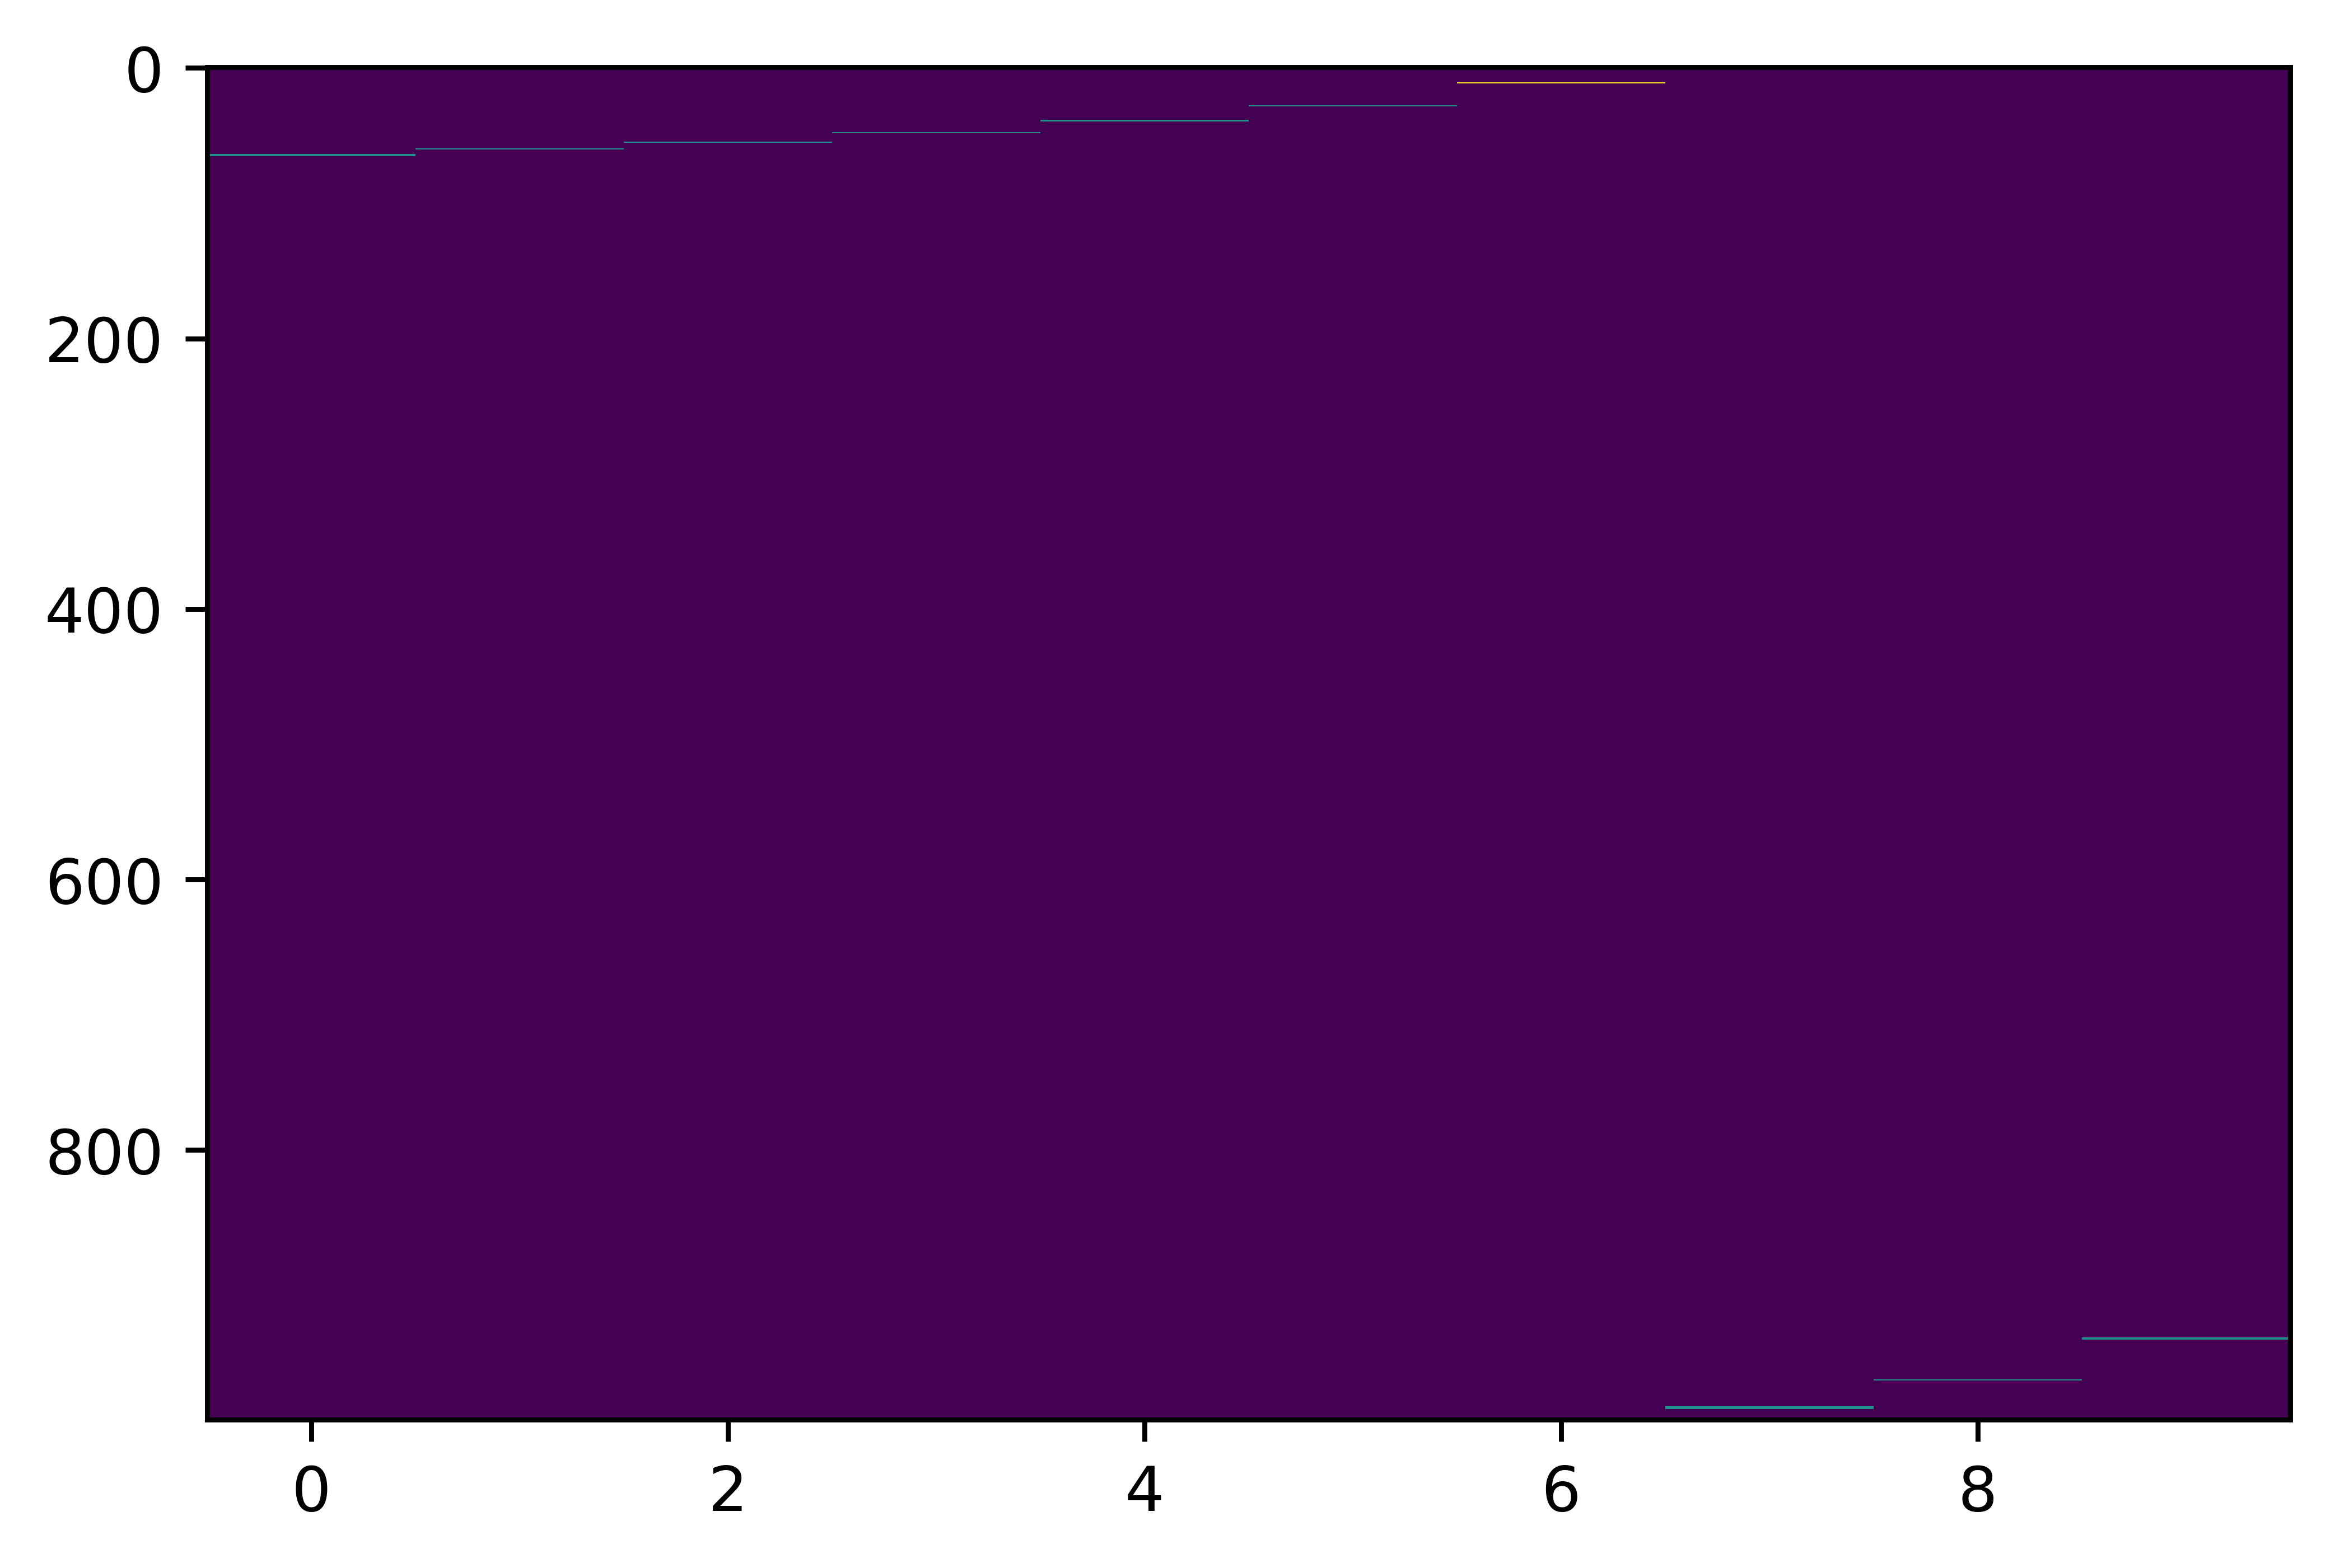

In [84]:
print(len(validTracks))
image = convertTrackToImage(validTracks[60])
plt.imshow(image, aspect="auto")
plt.show()
#plt.savefig("example.png", dpi=200)

In [4]:
images = []
train_y = np.empty((0, 2))
train_y_mag = np.empty((0, 1))

Data in files is event: 101, 103, 104 and 105

In [6]:
for k in range(80, 100):
    print("round:", k)
    if k < 10:
        event_prefix = 'event00000100' + str(k)
    else:
        event_prefix = 'event0000010' + str(k)
    hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
    cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
    selected_indices = hits.index[cond].tolist()
    selected_hits = hits.iloc[selected_indices]
    selected_truth = truth.iloc[selected_indices]
    # Create training set with tracks that are minimum of 5 hits
    tracks = selected_truth.particle_id.unique()
    validTracks = []
    for track in tracks:
        if track == 0:
            continue
        numberHits = selected_truth[selected_truth.particle_id == track].shape[0]
        #print(numberHits)
        #t = selected_truth[selected_truth.particle_id == track]
        if numberHits >= 12:
            validTracks.append(track)
            #print(track)

    nr = len(validTracks)
    for j in tqdm(range(nr)):
        trackId = validTracks[j]
        image = convertTrackToImage(trackId)
        images.append(image)
        #print(c)
    # Create train_Y (the momentum)
    for j, track in enumerate(validTracks[0:nr]):
        track = validTracks[j]
        if track == 0:
            continue
        t = selected_truth[selected_truth.particle_id == track]
        px = t['tpx'].mean()
        py = t['tpy'].mean()
        p = np.sqrt(px**2 + py**2)
        train_y = np.vstack([train_y, [px, py]])
        train_y_mag = np.vstack([train_y_mag, [p]])

round: 80


100%|██████████████████████████████████████████████████████████████████████████████| 1064/1064 [02:04<00:00,  8.55it/s]


round: 81


100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [01:33<00:00,  9.12it/s]


round: 82


100%|████████████████████████████████████████████████████████████████████████████████| 740/740 [01:20<00:00,  9.19it/s]


round: 83


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [02:05<00:00,  7.17it/s]


round: 84


100%|██████████████████████████████████████████████████████████████████████████████| 1078/1078 [01:51<00:00,  9.68it/s]


round: 85


100%|██████████████████████████████████████████████████████████████████████████████| 1061/1061 [02:01<00:00,  8.70it/s]


round: 86


100%|██████████████████████████████████████████████████████████████████████████████| 1039/1039 [01:49<00:00,  9.53it/s]


round: 87


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1226/1226 [02:11<00:00,  9.29it/s]


round: 88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 979/979 [01:48<00:00,  9.03it/s]


round: 89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 915/915 [01:36<00:00,  9.48it/s]


round: 90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [01:26<00:00,  9.74it/s]


round: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786/786 [01:25<00:00,  9.23it/s]


round: 92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996 [02:00<00:00,  8.29it/s]


round: 93


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1037/1037 [02:10<00:00,  7.94it/s]


round: 94


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 967/967 [01:57<00:00,  8.22it/s]


round: 95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 932/932 [02:22<00:00,  6.52it/s]


round: 96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 895/895 [02:09<00:00,  6.89it/s]


round: 97


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 974/974 [02:33<00:00,  6.35it/s]


round: 98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 866/866 [02:18<00:00,  6.26it/s]


round: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [02:30<00:00,  6.74it/s]


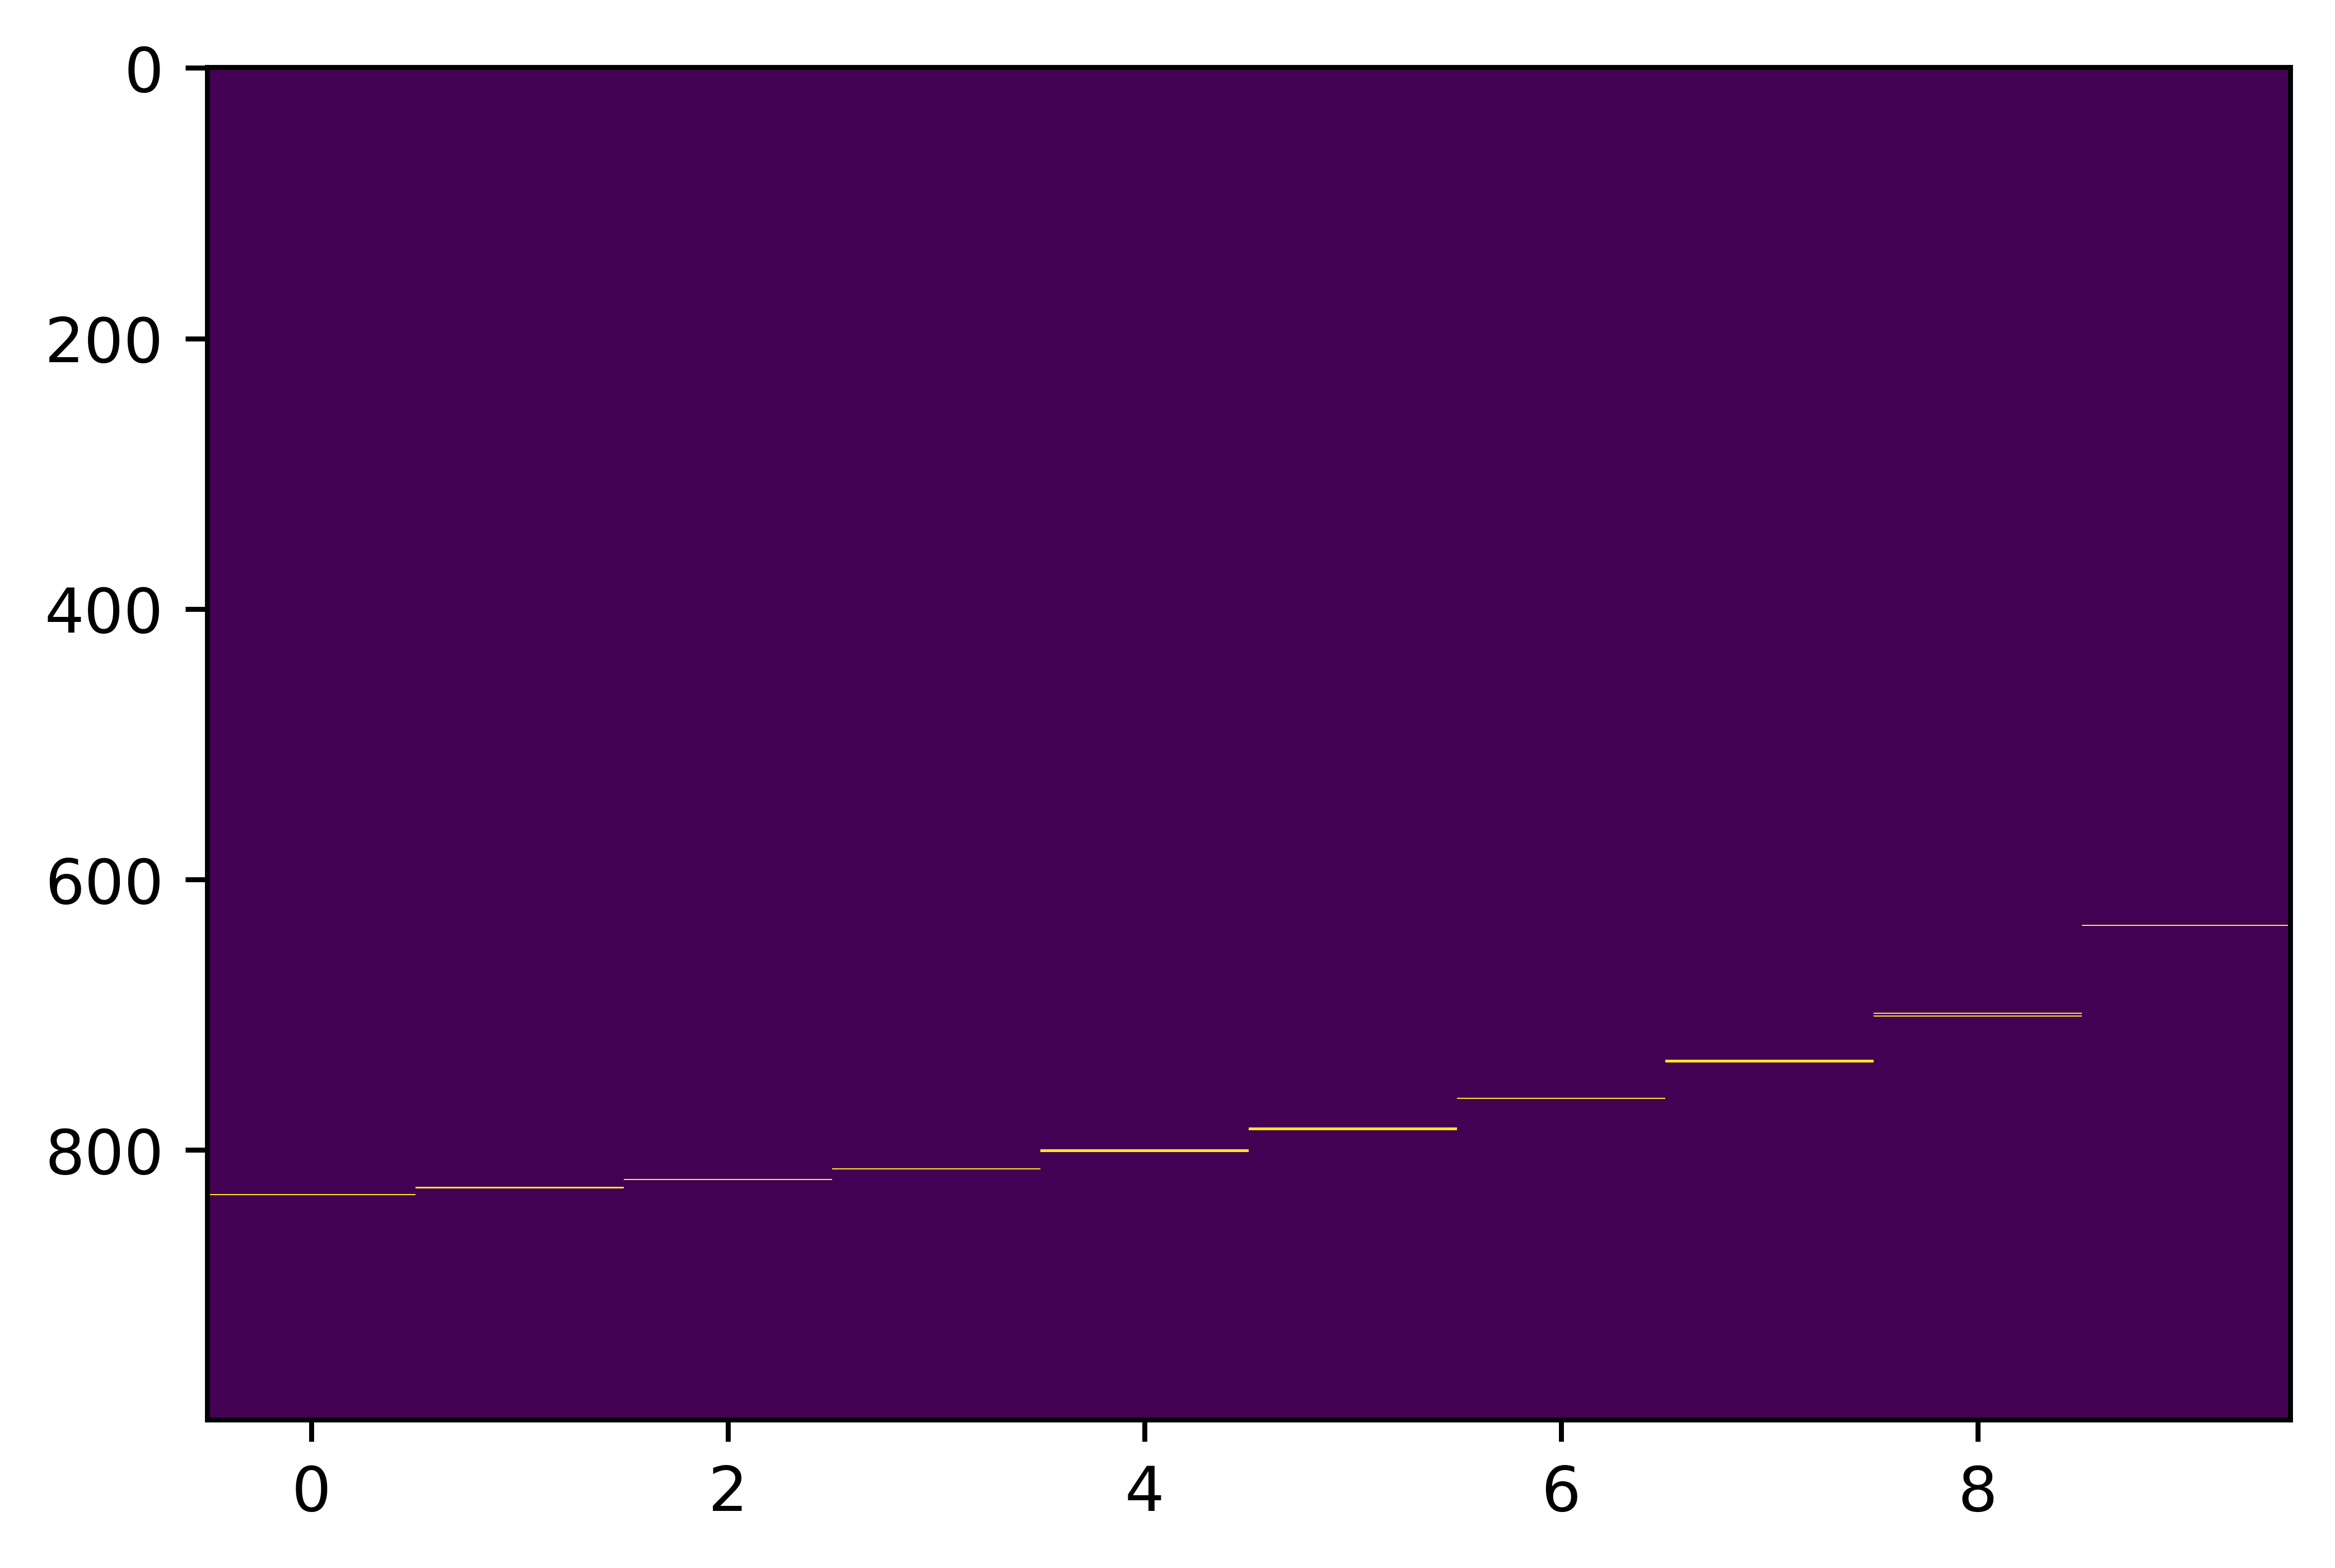

In [89]:
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 800
plt.imshow(images[50], aspect="auto")
plt.show()

In [51]:
images_val = []
train_y_val = np.empty((0, 2))
train_y_val_mag = np.empty((0, 1))

In [5]:
for k in range(0, 10):
    print("round:", k)
    event_prefix = 'event00000102' + str(k)
    hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
    cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
    selected_indices = hits.index[cond].tolist()
    selected_hits = hits.iloc[selected_indices]
    selected_truth = truth.iloc[selected_indices]
    # Create training set with tracks that are minimum of 5 hits
    tracks = selected_truth.particle_id.unique()
    validTracks = []
    for track in tracks:
        if track == 0:
            continue
        numberHits = selected_truth[selected_truth.particle_id == track].shape[0]
        t = selected_truth[selected_truth.particle_id == track]
        if numberHits >= 12:
            validTracks.append(track)

    nr = len(validTracks)
    for j in tqdm(range(nr)):
        trackId = validTracks[j]
        image = convertTrackToImage(trackId)
        images_val.append(image)
        #print(c)
    # Create train_Y (the momentum)
    for j, track in enumerate(validTracks[0:nr]):
        if track == 0:
            continue
        t = selected_truth[selected_truth.particle_id == track]
        px = t['tpx'].mean()
        py = t['tpy'].mean()
        #pz = t['tpz'].mean()
        p = np.sqrt(px**2 + py**2) #+ pz**2)# / (0.3 * 0.001 * 2)
        train_y_val_mag = np.vstack([train_y_val_mag, [p]])
        train_y_val = np.vstack([train_y_val, [px, py]])

round: 0


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [01:03<00:00, 11.92it/s]


round: 1


100%|████████████████████████████████████████████████████████████████████████████████| 868/868 [01:20<00:00, 10.77it/s]


round: 2


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:21<00:00, 10.92it/s]


round: 3


100%|█████████████████████| 1167/1167 [01:59<00:00,  9.75it/s]


round: 4


100%|█████████████████████| 1020/1020 [01:43<00:00,  9.83it/s]


round: 5


100%|█████████████████████| 1097/1097 [02:00<00:00,  9.09it/s]


round: 6


100%|███████████████████████| 988/988 [01:57<00:00,  8.43it/s]


round: 7


100%|███████████████████████| 993/993 [01:57<00:00,  8.45it/s]


round: 8


100%|█████████████████████| 1006/1006 [02:04<00:00,  8.06it/s]


round: 9


100%|███████████████████████| 929/929 [01:39<00:00,  9.29it/s]


In [7]:
train_y = np.reshape(train_y, (len(train_y), 2))
train_y_mag = np.reshape(train_y_mag, (len(train_y_mag), 1))
train_X = np.reshape(images, (len(images), B, 10, 1))

In [8]:
print(train_X.shape, train_y.shape, train_y_mag.shape)

(19169, 1000, 10, 1) (19169, 2) (19169, 1)


In [ ]:
#np.savez("", X=train_X, y=train_y, y_mag=train_y_mag, X_test=test_X, y_mag_test=test_y_mag, y_test=test_y)

In [9]:
#np.savez("all_2.npz", X=train_X, y=train_y, y_mag=train_y_mag)

In [9]:
#np.savez("test_set_104_and_105_1000.npz", X_test=test_X, y_test=test_y, y_test_mag=test_y_mag)